## Название, цели задачи проекта Определение клиентов склонных к оттоку компании



## Предварительный анализ исходных данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score, f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score,precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

In [2]:
df = pd.read_csv( '/datasets/final_provider/contract.csv')
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Пропусков нет, в колонках BeginDate и EndDate данные типа object, нужно привести к дате, а в колонке TotalCharges к типу float64

In [4]:
df1 = pd.read_csv( '/datasets/final_provider/personal.csv')
df1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Пропусков нет

In [6]:
df2 = pd.read_csv( '/datasets/final_provider/internet.csv')
df2.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Пропусков нет

In [8]:
df3 = pd.read_csv( '/datasets/final_provider/phone.csv')
df3.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [9]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Пропусков нет

Нужно объеденить все датасеты в один, сделать предобработку: изменить типы данных, заполнить пропуски, удалить дубликаты, заполнить или удалить недостающиее значения. В первых двух датасетах количество строк совпадает, в остальных меньше.

 ## Предобработка данных

Объеденим все таблицы в одну

In [10]:
total = df.merge(df1, on='customerID', how='left')
total = total.merge(df2, on='customerID', how='left')
total = total.merge(df3, on='customerID', how='left')
total.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [11]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


В данных с меньшим количеством строк образовались пропуски,
заполним их значением No, тк данных нет из-за того, что пользователи не пользовались этой услугой

In [12]:
total['InternetService'] = total['InternetService'].fillna('No')
total['OnlineSecurity'] = total['OnlineSecurity'].fillna('No')
total['OnlineBackup'] = total['OnlineBackup'].fillna('No')
total['DeviceProtection'] = total['DeviceProtection'].fillna('No')
total['TechSupport'] = total['TechSupport'].fillna('No')
total['StreamingTV'] = total['StreamingTV'].fillna('No')
total['StreamingMovies'] = total['StreamingMovies'].fillna('No')
total['MultipleLines'] = total['MultipleLines'].fillna('No')
total['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [13]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


Пропуски заполнены

В колонке EndDate целевой признак, дата ухода из компании, No - человек пользуется услугами компании.
Создадим колонку с целевыми признаками 1 и 0, где 1 - человек ушел, 0 - остался. Можно заменить No на дату 02.02.2020, на которую выгружен датасет.


In [14]:
total['Target_END'] = np.where(total['EndDate'] == 'No', 0, 1)
total.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Target_END
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,No,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,1


In [15]:
total['EndDate'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

In [16]:
total['EndDate'].loc[total['EndDate'] == 'No'] = '2020-02-01 00:00:00'
total['EndDate'].unique()

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


array(['2020-02-01 00:00:00', '2019-12-01 00:00:00',
       '2019-11-01 00:00:00', '2019-10-01 00:00:00',
       '2020-01-01 00:00:00'], dtype=object)

In [17]:
total.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Target_END
0,7590-VHVEG,2020-01-01,2020-02-01 00:00:00,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,0
1,5575-GNVDE,2017-04-01,2020-02-01 00:00:00,One year,No,Mailed check,56.95,1889.5,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,1
3,7795-CFOCW,2016-05-01,2020-02-01 00:00:00,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,No,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,1


Приведем данные в колонках BeginDate и EndDate к типу datetime

In [18]:
total['BeginDate'] = pd.to_datetime(total['BeginDate'], format='%Y-%m-%d %H:%M')
total['EndDate'] = pd.to_datetime(total['EndDate'], format='%Y-%m-%d %H:%M')
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

При попытке привести данные в колонке TotalCharges выдает ошибку

In [19]:
total['TotalCharges'].describe(include='object')

count     7043
unique    6531
top       20.2
freq        11
Name: TotalCharges, dtype: object

In [20]:
total['TotalCharges'].value_counts()

20.2       11
           11
19.75       9
20.05       8
19.9        8
           ..
140.95      1
1849.95     1
6300.85     1
3210.35     1
177.4       1
Name: TotalCharges, Length: 6531, dtype: int64

In [21]:
total.loc[total['TotalCharges'] ==' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Target_END
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,...,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,Female,0,...,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,Male,0,...,Yes,No,No,No,No,No,No,No,Yes,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,Female,0,...,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,Male,0,...,Yes,No,No,No,No,No,No,No,Yes,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,Female,0,...,Yes,No,No,No,No,No,No,No,No,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,Female,0,...,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0


В 11 строчках в колонке TotalCharges вместо значений пробел, количество небольшое можно удалить

In [22]:
total = total.loc[total['TotalCharges'] !=' ']
total['TotalCharges'] = total['TotalCharges'].astype('float')
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7032 non-null   object        
 9   SeniorCitizen     7032 non-null   int64         
 10  Partner           7032 non-null   object        
 11  Dependents        7032 non-null   object        
 12  InternetService   7032 non-null   object        
 13  OnlineSecurity    7032 non-null   object        
 14  OnlineBackup      7032 n

Добавим колонку с периодом, который пользователь пользуется услугами компании

In [23]:
total['TotalDate'] = (total['EndDate']-total['BeginDate']).dt.days
total['TotalDate'].head()

0      31
1    1036
2      61
3    1371
4      61
Name: TotalDate, dtype: int64

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>нужный фактор, здорово.

In [24]:
df.duplicated().sum()

0

Дубликатов нет

<AxesSubplot:>

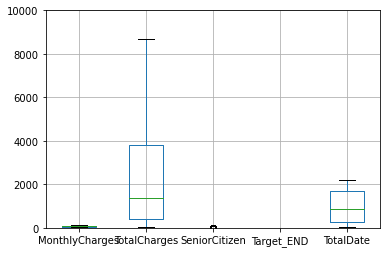

In [25]:
plt.ylim(0, 10000)
total.boxplot()

Выбросов нет

Объединила датасеты, заполнила пропуски, выделила целевой признак, изменила типы данных, добавила колонку TotalDate,дубликатов нет


 ## Исследование данных (EDA)

Посмотрим корпеляцию между признаками

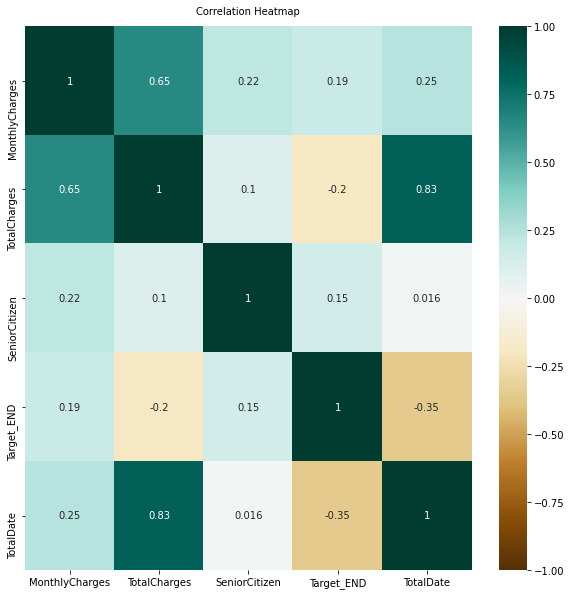

In [26]:
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(total.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG') 
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10}, pad=12);
plt.show()

Высокая корреляция между признаками Суммарные расходы и период использования

Создадим датасет с клиентами, которые покинули компанию

In [27]:
total_end = total.loc[total['Target_END'] == 1]
total_end.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Target_END,TotalDate
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,1,61
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,Fiber optic,No,No,No,No,No,No,No,1,61
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,Female,0,...,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,1,245
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,...,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,1,853
13,0280-XJGEX,2015-09-01,2019-10-01,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Male,0,...,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,1,1491


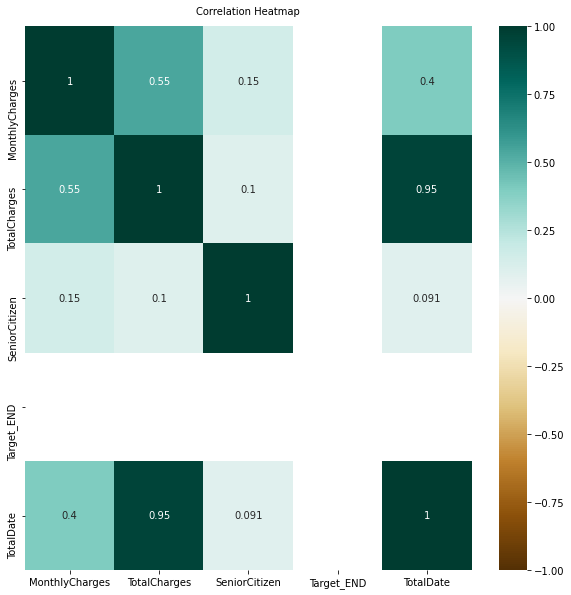

In [28]:
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(total_end.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG') 
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10}, pad=12);
plt.show()

Тут такая же корреляция

Посмотрим какими услугами пользовались большинство из ушедших

In [29]:
total_end.describe(include='object')

,customerID,Type,PaperlessBilling,PaymentMethod,gender,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869
unique,1869,3,2,4,2,2,2,3,2,2,2,2,2,2,2
top,6214-EDAKZ,Month-to-month,Yes,Electronic check,Female,No,No,Fiber optic,No,No,No,No,No,No,No
freq,1,1655,1400,1071,939,1200,1543,1297,1574,1346,1324,1559,1055,1051,1019


Всего ушло 1869 человек

1655 из них платили помесячно(Month-to-month)

1400 использовали услугу PaperlessBilling

1071 платили электронными чеками Electronic check

Женщин и мужчин примерно одинаково

У большинства не было доп услуг (OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV,StreamingMovies, MultipleLines), но была услуга Fiber optic

Также они не являлись партнерами(Partner) и у них нет иждевенцев (Dependents)

In [30]:
total_end.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen,Target_END,TotalDate
count,1869.000000,1869.000000,1869.000000,1869.0,1869.000000
mean,74.441332,1531.796094,0.254682,1.0,547.352060
std,24.666053,1890.822994,0.435799,0.0,594.389607
min,18.850000,18.850000,0.000000,1.0,30.000000
25%,56.150000,134.500000,0.000000,1.0,61.000000
50%,79.650000,703.550000,0.000000,1.0,304.000000
75%,94.200000,2331.300000,1.000000,1.0,883.000000
max,118.350000,8684.800000,1.000000,1.0,2191.000000


Посмотрим дополнительно гистограммы

<AxesSubplot:>

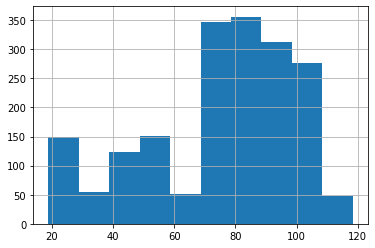

In [31]:
total_end['MonthlyCharges'].hist(bins=10)

Уходят чаще с высокими помесечными платами

<AxesSubplot:>

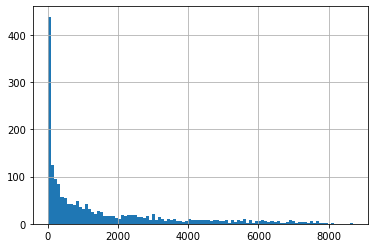

In [32]:
total_end['TotalCharges'].hist(bins=100)

Но реже, те у кого больше сумма опщих трат

<AxesSubplot:>

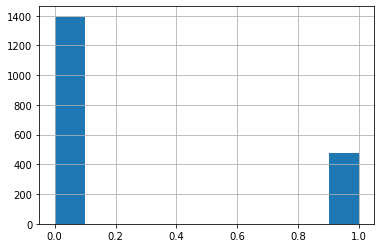

In [33]:
total_end['SeniorCitizen'].hist(bins=10)

пенсионеры уходят реже

<AxesSubplot:>

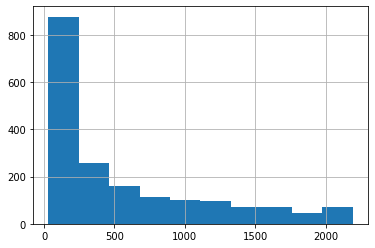

In [34]:
total_end['TotalDate'].hist(bins=10)

Чаще всего уходят люди, которые с компанией менее 1 года

Итак, чаще всего уходят люди, которые недавно подключились, работающие без иждевенцев, выбравшие тариф оплаты от месяца к месяцу с помощью электронного чека, которые платят за оптоволокно

## Подбор и обучение модели

Для начала удалим признаки, которые не сможем преобразовать в количественные

In [35]:
total = total.drop(columns = ['customerID','BeginDate','EndDate'], axis = 1)

Закодируем категориальные признаки

In [36]:
total_ohe = pd.get_dummies(total, drop_first=True)
total_ohe.head()

,MonthlyCharges,TotalCharges,SeniorCitizen,Target_END,TotalDate,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
0,29.85,29.85,0,0,31,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
1,56.95,1889.50,0,0,1036,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,53.85,108.15,0,1,61,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
3,42.30,1840.75,0,0,1371,1,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
4,70.70,151.65,0,1,61,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0


In [37]:
total_train, total_valid, total_test = np.split(total_ohe, [int(.6*len(total)), int(.80*len(total))])
display(total_train.shape)
display(total_valid.shape)
display(total_test.shape)

(4219, 23)

(1406, 23)

(1407, 23)

In [38]:
features_train = total_train.drop(['Target_END'], axis=1)
target_train = total_train['Target_END']
features_valid = total_valid.drop(['Target_END'], axis=1)
target_valid = total_valid['Target_END']
features_test = total_test.drop(['Target_END'], axis=1)
target_test = total_test['Target_END']

In [39]:
target_train.mean()

0.26214742830054516

In [40]:
target_train.value_counts(normalize=False)

0    3113
1    1106
Name: Target_END, dtype: int64

Соотношение положительных ответов к отрицательным 1:3
    
проведем балансировку классов

In [41]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

In [42]:
target_upsampled.value_counts(normalize=False)

1    3318
0    3113
Name: Target_END, dtype: int64

In [43]:
acc_list = []

for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=80082, max_depth=depth) 
    model.fit(features_upsampled, target_upsampled)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    acc_list.append((roc_auc_score(target_valid, probabilities_one_valid), depth))

predictions_valid = model.predict(features_valid)
    
display("Лучшее значение roc_auc:", max(acc_list))
display("Accuracy:", accuracy_score(target_valid, predictions_valid))


'Лучшее значение roc_auc:'

(0.8153683327879581, 5)

'Accuracy:'

0.6756756756756757

'Лучшее значение roc_auc:'

0.8444095631544501

70

7

'Accuracy:'

0.7724039829302988

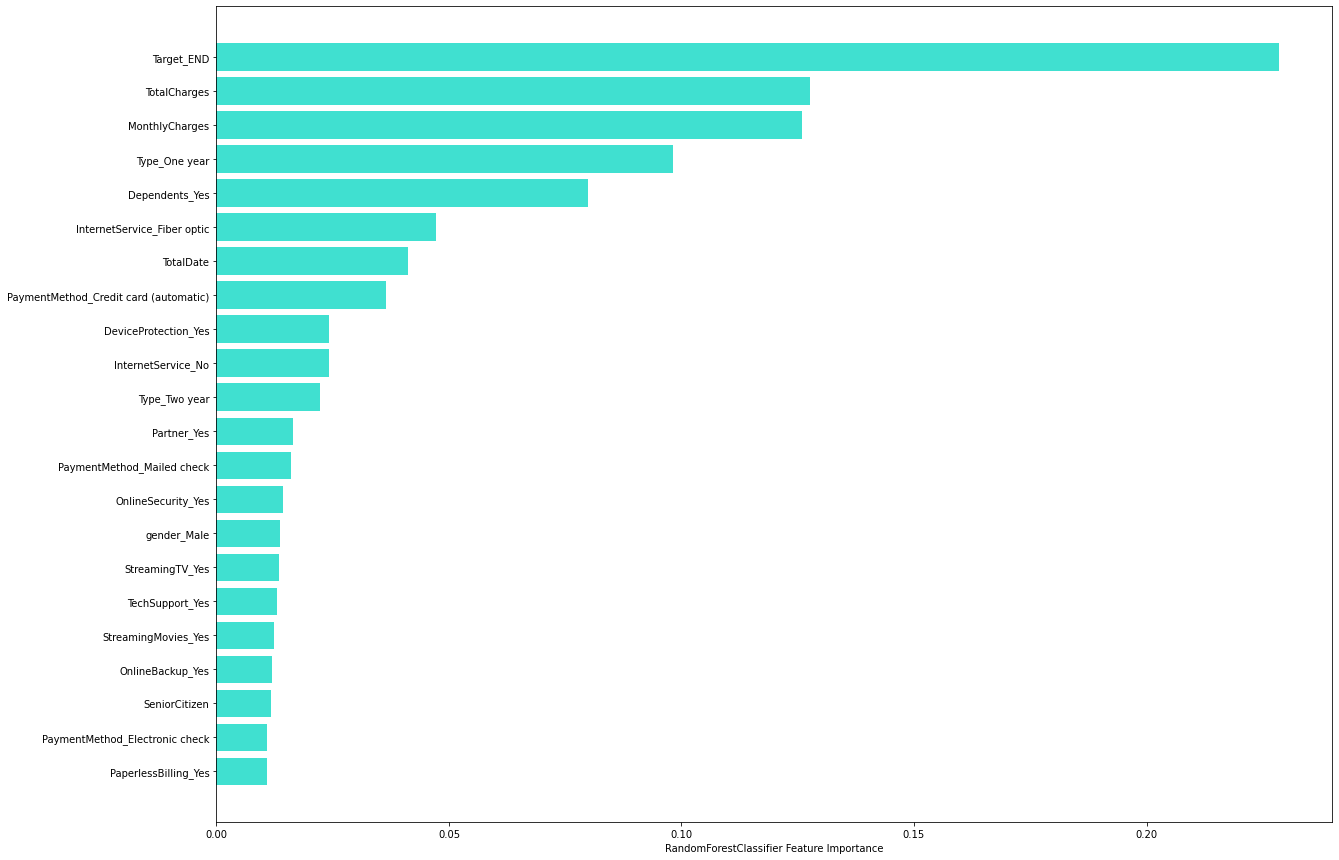

In [44]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 100, 10):
    for depth in range (1, 12):
        model = RandomForestClassifier(random_state=80082, n_estimators=est, max_depth=depth) 
        model.fit(features_upsampled, target_upsampled) 
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        result = roc_auc_score(target_valid, probabilities_one_valid) 
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth
predictions_valid = model.predict(features_valid) 

display("Лучшее значение roc_auc:", best_result, best_est, best_depth)
display("Accuracy:", accuracy_score(target_valid, predictions_valid))

sorted_feature_importance = model.feature_importances_.argsort()
plt.figure(figsize=(20, 15))
plt.barh(total_ohe.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("RandomForestClassifier Feature Importance")
plt.show()

In [45]:
model = LogisticRegression(random_state=80082, solver='liblinear',class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

display("auc_roc:", auc_roc)
display("accuracy:", accuracy_score(target_valid, predicted_valid))

'auc_roc:'

0.83170913776178

'accuracy:'

0.7425320056899004

'Лучшее значение roc_auc:'

0.8786186497873038

'Accuracy:'

0.7724039829302988

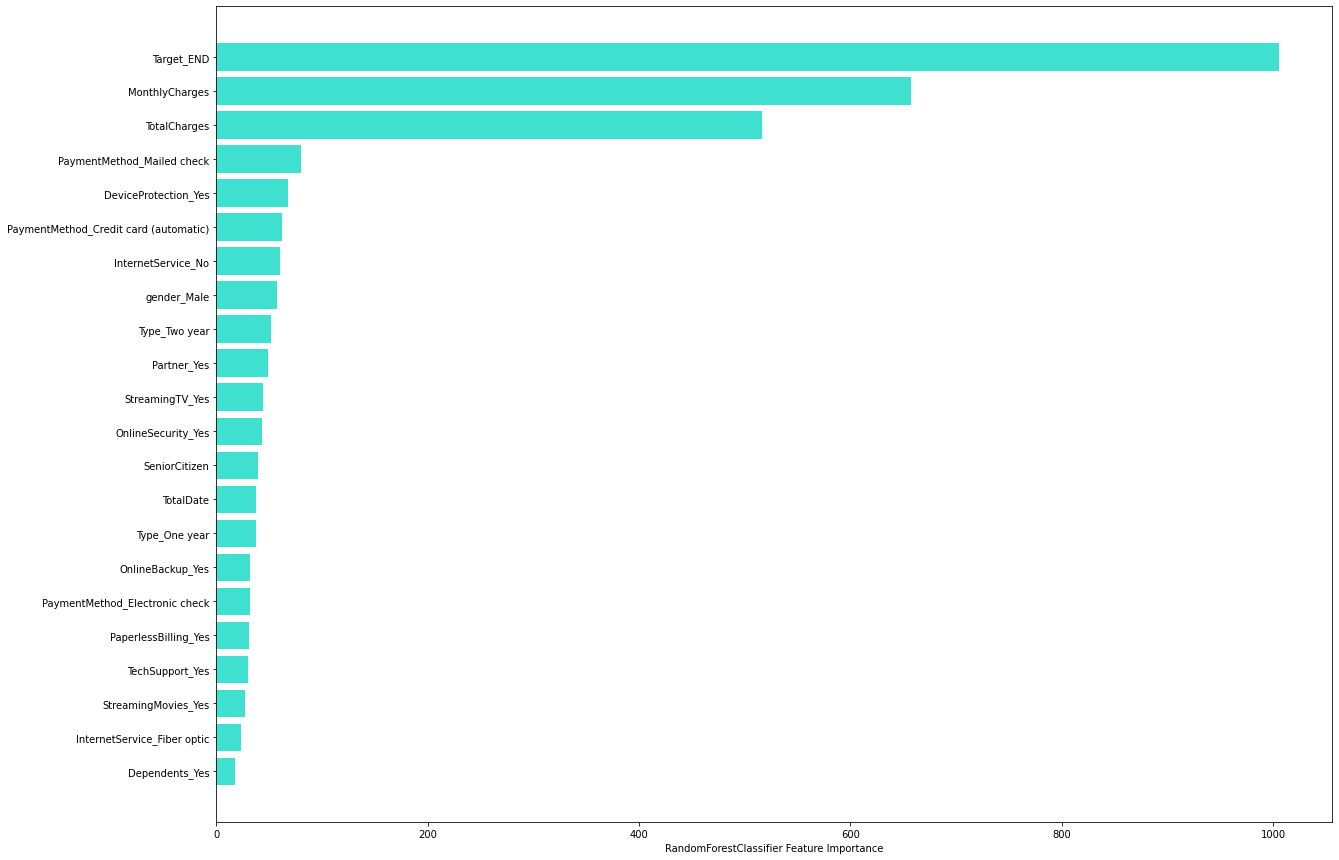

In [46]:
model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=- 1,
                           learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, 
                           objective=None, class_weight=None, min_split_gain=0.0,
                           min_child_weight=0.001, min_child_samples=20,
                           subsample=1.0, subsample_freq=0, colsample_bytree=1.0,
                           reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1,
                           importance_type='split')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

display("Лучшее значение roc_auc:", auc_roc)
display("Accuracy:", accuracy_score(target_valid, predictions_valid))

sorted_feature_importance = model.feature_importances_.argsort()
plt.figure(figsize=(20, 15))
plt.barh(total_ohe.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("RandomForestClassifier Feature Importance")
plt.show()

Learning rate set to 0.022807
0:	learn: 0.6805449	total: 49.7ms	remaining: 49.7s
10:	learn: 0.5895232	total: 75.7ms	remaining: 6.81s
20:	learn: 0.5401799	total: 103ms	remaining: 4.78s
30:	learn: 0.5074294	total: 129ms	remaining: 4.02s
40:	learn: 0.4843337	total: 154ms	remaining: 3.61s
50:	learn: 0.4680660	total: 181ms	remaining: 3.36s
60:	learn: 0.4567987	total: 207ms	remaining: 3.19s
70:	learn: 0.4481206	total: 234ms	remaining: 3.07s
80:	learn: 0.4403613	total: 269ms	remaining: 3.05s
90:	learn: 0.4339693	total: 302ms	remaining: 3.02s
100:	learn: 0.4278817	total: 328ms	remaining: 2.92s
110:	learn: 0.4231034	total: 365ms	remaining: 2.92s
120:	learn: 0.4185938	total: 393ms	remaining: 2.85s
130:	learn: 0.4136110	total: 421ms	remaining: 2.79s
140:	learn: 0.4082445	total: 457ms	remaining: 2.79s
150:	learn: 0.4047824	total: 491ms	remaining: 2.76s
160:	learn: 0.4005592	total: 531ms	remaining: 2.77s
170:	learn: 0.3973964	total: 568ms	remaining: 2.75s
180:	learn: 0.3947750	total: 607ms	remainin

'Лучшее значение roc_auc:'

0.8811316365346858

'Accuracy:'

0.7724039829302988

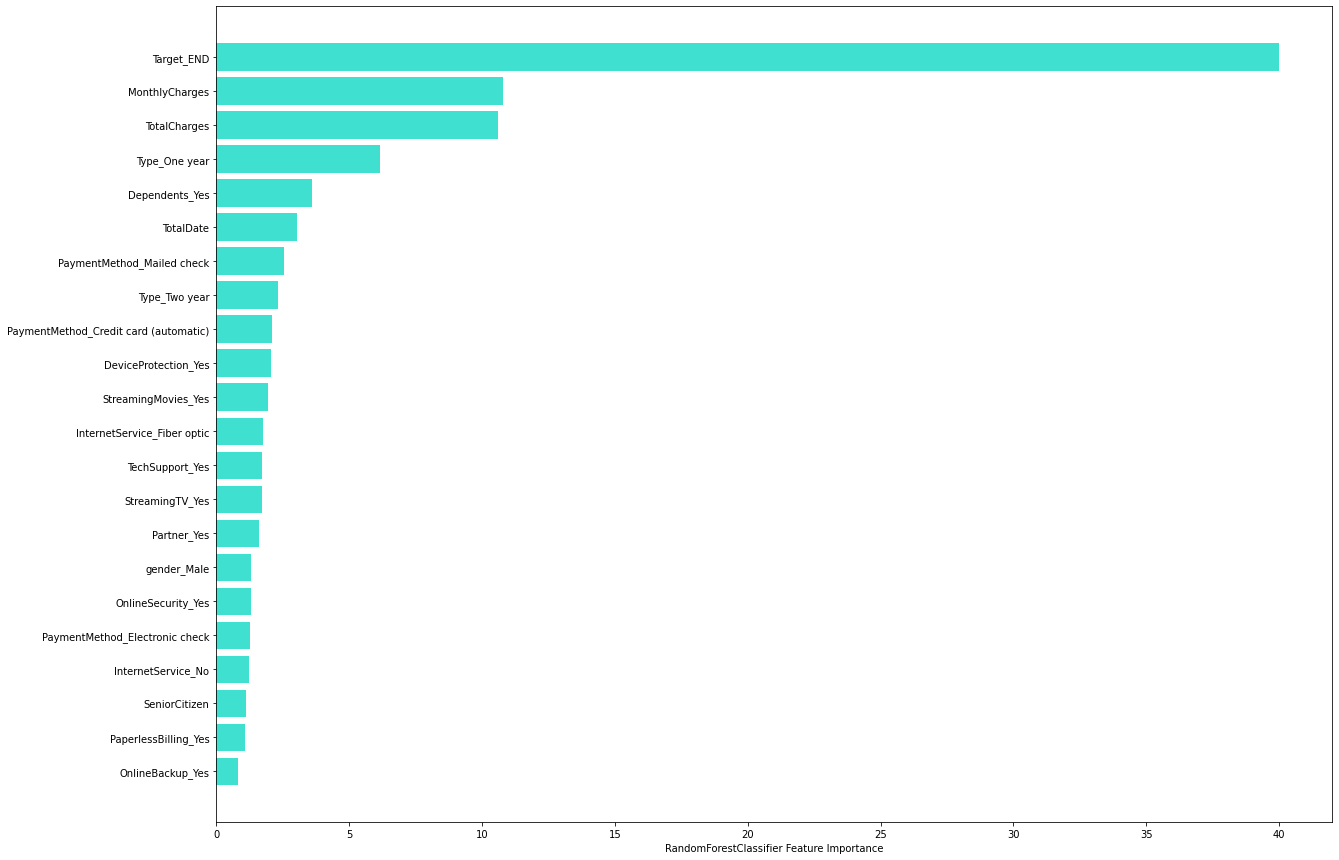

CPU times: user 3.35 s, sys: 146 ms, total: 3.5 s
Wall time: 4.34 s


In [47]:
%%time
model = CatBoostClassifier()
model.fit(features_upsampled, target_upsampled, verbose=10)
predicted_valid = model.predict(features_valid) 

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

display("Лучшее значение roc_auc:", auc_roc)
display("Accuracy:", accuracy_score(target_valid, predictions_valid))

sorted_feature_importance = model.feature_importances_.argsort()
plt.figure(figsize=(20, 15))
plt.barh(total_ohe.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("RandomForestClassifier Feature Importance")
plt.show()

Лучший результат у модели CatBoostClassifier

In [48]:
def grid_search(model,params,scoring,features,target):
    model_random = GridSearchCV(model,params,cv=5, n_jobs=-1,scoring=scoring)
    model_random.fit(features,target)
    best_params_random = model_random.best_params_
    best_score_random = model_random.best_score_
    return model_random,best_params_random,best_score_random

In [49]:
Cat_params = {'iterations': range(1,20), 'depth': range(1,10)}


In [50]:
model_random,best_params_random,best_score_random = grid_search(CatBoostClassifier(random_state=80082),
                                                                Cat_params,'roc_auc',features_train,target_train)

Learning rate set to 0.5
0:	learn: 0.5662279	total: 738us	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5656107	total: 721us	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5393268	total: 1.37ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5635012	total: 1.31ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5308962	total: 738us	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5662279	total: 663us	remaining: 663us
1:	learn: 0.5003539	total: 1.41ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5656107	total: 737us	remaining: 737us
1:	learn: 0.5136864	total: 1.63ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5393268	total: 794us	remaining: 794us
1:	learn: 0.5000246	total: 1.53ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5635012	total: 716us	remaining: 716us
1:	learn: 0.5115880	total: 1.36ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5308962	total: 831us	remaining: 831us
1:	learn: 0.4859805	total: 1.85ms	remaining: 0us
Learning rate

In [51]:
model_random,best_params_random,best_score_random

(GridSearchCV(cv=5,
              estimator=<catboost.core.CatBoostClassifier object at 0x7f3e4d3d4970>,
              n_jobs=-1,
              param_grid={'depth': range(1, 10), 'iterations': range(1, 20)},
              scoring='roc_auc'),
 {'depth': 4, 'iterations': 19},
 0.8809199436307373)

## Проверка модели

In [52]:
model = CatBoostClassifier(random_state=80082,iterations=19, depth=4 )
model.fit(features_train, target_train) 

predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

display("roc_auc")
display("Тестовая выборка:" , roc_auc_score(target_test, probabilities_one_test))
display("Accuracy")
display("Тестовая выборка::", accuracy_score(target_test, predicted_test))

Learning rate set to 0.5
0:	learn: 0.4862442	total: 1.28ms	remaining: 23.1ms
1:	learn: 0.4258761	total: 2.68ms	remaining: 22.8ms
2:	learn: 0.4016505	total: 4.05ms	remaining: 21.6ms
3:	learn: 0.3930132	total: 5.56ms	remaining: 20.9ms
4:	learn: 0.3876425	total: 6.99ms	remaining: 19.6ms
5:	learn: 0.3797821	total: 8.3ms	remaining: 18ms
6:	learn: 0.3781297	total: 9.63ms	remaining: 16.5ms
7:	learn: 0.3685689	total: 11.1ms	remaining: 15.2ms
8:	learn: 0.3656691	total: 12.4ms	remaining: 13.8ms
9:	learn: 0.3627355	total: 13.8ms	remaining: 12.5ms
10:	learn: 0.3614072	total: 15.3ms	remaining: 11.1ms
11:	learn: 0.3592871	total: 16.5ms	remaining: 9.63ms
12:	learn: 0.3511563	total: 17.9ms	remaining: 8.26ms
13:	learn: 0.3402487	total: 19.3ms	remaining: 6.89ms
14:	learn: 0.3388927	total: 20.5ms	remaining: 5.48ms
15:	learn: 0.3374402	total: 21.9ms	remaining: 4.1ms
16:	learn: 0.3328703	total: 23.1ms	remaining: 2.72ms
17:	learn: 0.3288240	total: 24.2ms	remaining: 1.35ms
18:	learn: 0.3263264	total: 25.5ms	

'roc_auc'

'Тестовая выборка:'

0.8743956347561819

'Accuracy'

'Тестовая выборка::'

0.8329779673063256

Удалось предалеть требуемый порог качества для модели

In [53]:
dummy = DummyClassifier(strategy='uniform').fit(features_train,target_train)
dummy_pred = dummy.predict(features_test)
print('Test accuracy: ',  accuracy_score(target_test, dummy_pred))
print('Test score roc_auc: ', roc_auc_score(target_test, dummy_pred))

Test accuracy:  0.48756218905472637
Test score roc_auc:  0.49600927077097823


Наша модель предсказывает лучше, чем простая фиктивная модель

<div class="alert alert-block alert-info">
<b>Комментарий студента:
    
    На стандартных настройках качество показала лучше CatBoostClassifier
    Поэтому подобрала параметры для нее
    Вывела графики важности факторов. Самые мало значимые факторы для CatBoostClassifier OnlineBackup(онлайн поддержка), пол и гражданство.
    Самые важные траты время изпользование,помесячные и итого траты, период оплаты, и чуть в меньшей степени наличие иждевенцев
    
   
    
</div>

Удалось выбрать и обучить модель, которая соответствует заданной задаче:

Находить клиентов склонных к оттоку